In [1]:
from src.wgan import WassersteinGAN

from src.utils.make_discriminator import make_discriminator
from src.utils.make_generator import make_generator

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data

In [2]:
len_input_seq = 2
len_generated_seq = 2
#X_train, X_val, X_test, X_train_z, X_val_z, X_test_z, cX_train, cX_val, cX_test = get_gan_dataset(len_input_seq)

In [3]:
def get_data():
    import pickle

    with open('data/new_data_obj.pkl', 'rb') as f:
        X_train, cX_train, X_train_z = pickle.load(f)

    # split the training set into training and validation
    n_sample_train = int(X_train.shape[0] * 0.8)

    X_train, X_val = X_train[:n_sample_train], X_train[n_sample_train:]
    cX_train, cX_val = cX_train[:n_sample_train], cX_train[n_sample_train:]
    X_train_z, X_val_z = X_train_z[:n_sample_train], X_train_z[n_sample_train:]

    len_input_seq = X_train.shape[1] # 6
    len_generated_seq = 4

    return X_train, X_val, X_train_z, X_val_z, cX_train, cX_val, len_input_seq, len_generated_seq

X_train, X_val, X_train_z, X_val_z, cX_train, cX_val, len_input_seq, len_generated_seq = get_data()

### Models

In [4]:
generator = make_generator(
    image_dim=[3, 64, 64],
    latent_dim=1280,
    conditions_dim=6,
    len_input_seq=len_input_seq,
    len_output_seq=len_generated_seq,
    n_filters=[16, 8, 8],
    kernel_size=[5, 3, 1],
    stride=[1, 1, 1],
    padding=['same', 'same', 'same'],
    hidden_dims=[128, 128],
)

discriminator = make_discriminator(
    input_dim=[3, 64, 64],
    len_input_seq=min(len_input_seq, len_generated_seq),
)

gan = WassersteinGAN(
    generator=generator,
    discriminator=discriminator,
    len_input_seq=len_input_seq,
    len_generated_seq=len_generated_seq,
    patience=5,
    learning_rate_generator=0.01,
    learning_rate_discriminator=0.01,
    n_critic=5,  # number of critic updates per generator update
    clip_value=0.01,
    discriminator_gradient_penalty_weight=0.02,
    generator_wloss_weight=0.5,
    generator_flow_loss_weight=0.3,
    generator_mse_weight=0.15,
    color_weight=0.05,
    save_path = 'wgan_train_obj'
)

### Train

In [5]:
gan.train(
    X_train_z, X_train, cX_train, # noise, real images, conditions
    X_val_z, X_val, cX_val,
    epochs=20, batch_size=32
)

Epoch 1/20
Batch 1/17 - Generator Loss: 0.03904927521944046, Discriminator Loss: 1.290865182876587
Batch 2/17 - Generator Loss: 0.06828755140304565, Discriminator Loss: 0.9397892355918884
Batch 3/17 - Generator Loss: 0.01687077060341835, Discriminator Loss: 0.9540318846702576
Batch 4/17 - Generator Loss: -0.013127319514751434, Discriminator Loss: 0.9814950823783875
Batch 5/17 - Generator Loss: -0.014496609568595886, Discriminator Loss: 0.9776163101196289
Batch 6/17 - Generator Loss: -0.029345087707042694, Discriminator Loss: 0.989937961101532
Batch 7/17 - Generator Loss: -0.030496295541524887, Discriminator Loss: 0.9801031351089478
Batch 8/17 - Generator Loss: -0.04166465252637863, Discriminator Loss: 0.9992740154266357
Batch 9/17 - Generator Loss: -0.04615909606218338, Discriminator Loss: 1.0269243717193604
Batch 10/17 - Generator Loss: -0.05921107903122902, Discriminator Loss: 1.0313771963119507
Batch 11/17 - Generator Loss: -0.05767706409096718, Discriminator Loss: 1.038743495941162

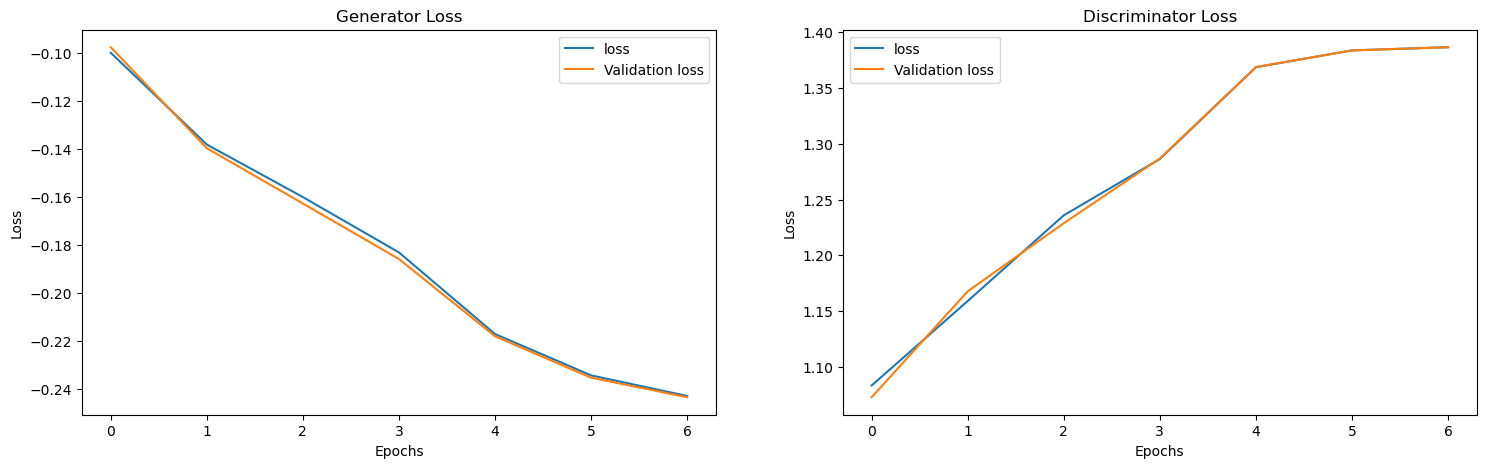

In [6]:
gan.visualize_loss()

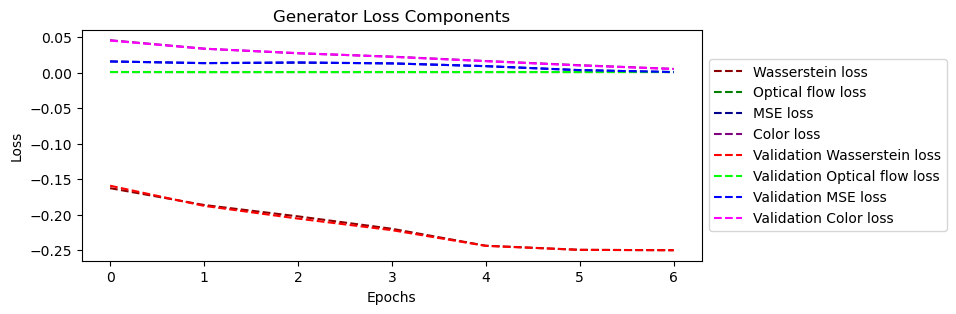

In [7]:
gan.visualize_generator_loss_components()

In [8]:
i=10

X = X_train[i]
z = X_train_z[i]
cX = cX_train[i]

a = gan.generate(X, z, cX)[0]

a.max(), a.min(), a.mean(), X_train[i].max(), X_train[i].min(), X_train[i].mean()

(0.99867386, 0.1609549, 0.34425926, 1.0, 0.0, 0.36163604)

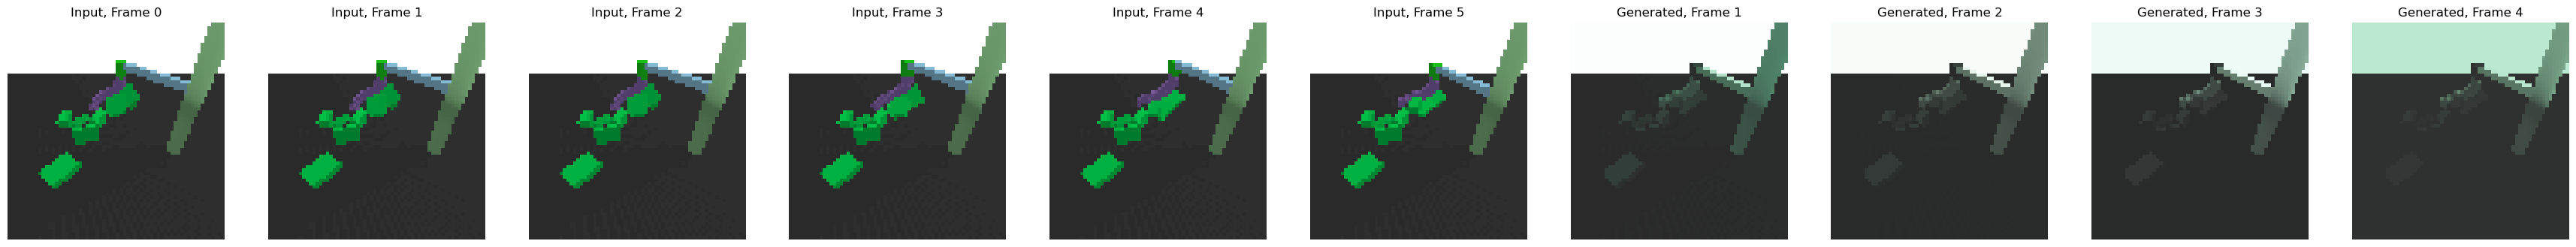

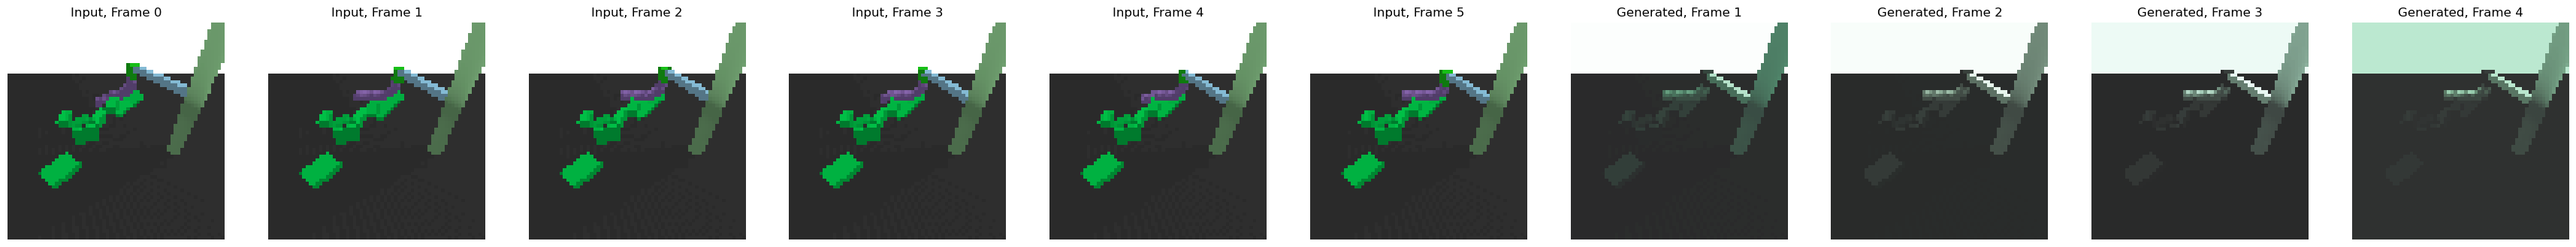

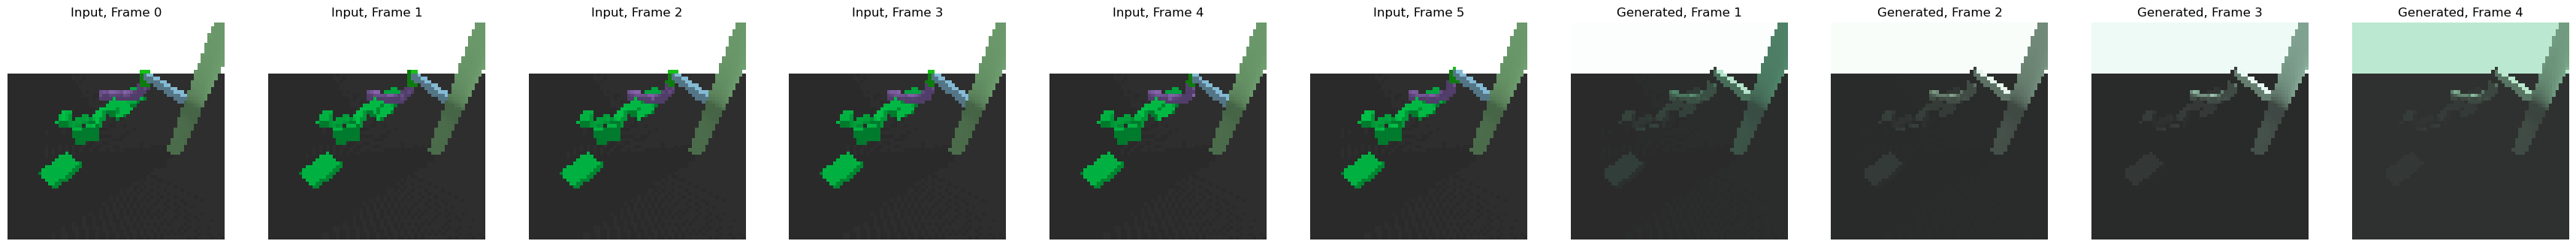

In [9]:
for i in range(2, 5):
    X = X_train[i]
    z = X_train_z[i]
    cX = cX_train[i]

    gan.visualize_generated_image(X, z, cX)

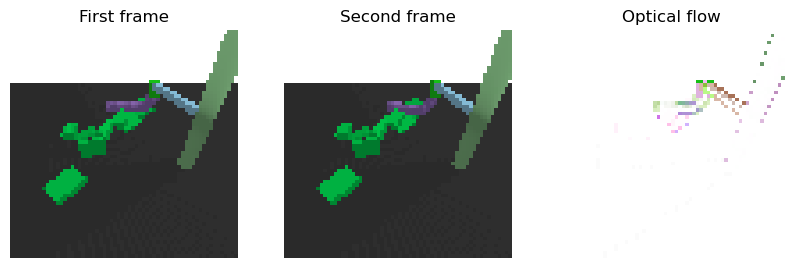

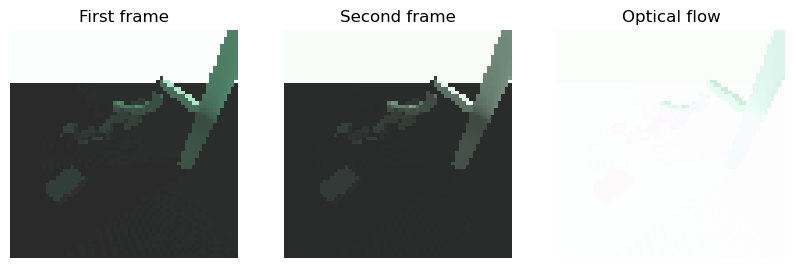

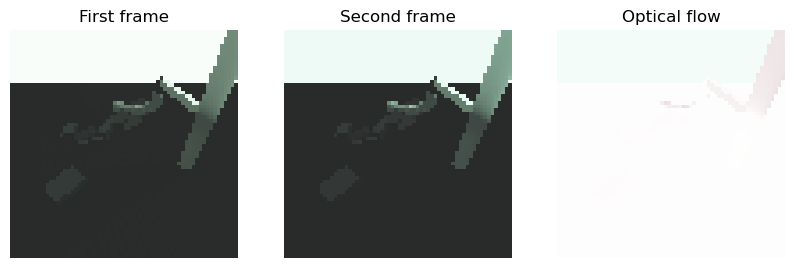

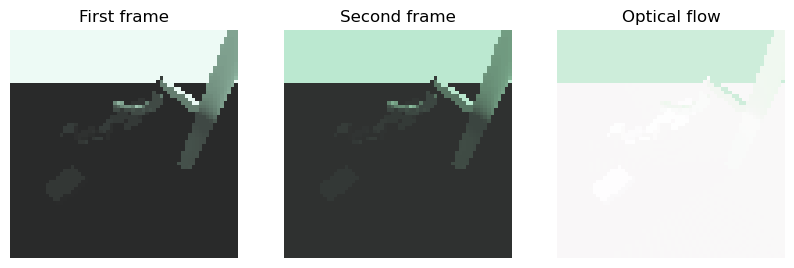

In [10]:
for i in range(4, 5):
    X = X_train[i]
    z = X_train_z[i]
    cX = cX_train[i]

    a = gan.generate(X, z, cX)

    from src.utils.optical_flow import draw_optical_flow

    draw_optical_flow(X[0], X[1])
    for i in range(len_generated_seq-1):
        draw_optical_flow(a[0][i], a[0][i+1])


In [12]:
from skimage import img_as_ubyte
import imageio
import numpy as np

def generate_gif(images, name):
    images = [img_as_ubyte(image) for image in images]
    images = [np.transpose(image, (1, 2, 0)) for image in images]
    imageio.mimsave(f'{name}.gif', images)

def generate_gif_gray(images, name):
    images = [img_as_ubyte(image) for image in images]
    imageio.mimsave(f'{name}.gif', images)

for i in range(0, X_train.shape[0]):
    X = X_train[i]
    z = X_train_z[i]
    cX = cX_train[i]

    images_list = gan.generate(X, z, cX)[0]

    images_list = np.concatenate((X, images_list), axis=0)

    # image to gray scale
    images_list_bw = np.zeros((images_list.shape[0], images_list.shape[2], images_list.shape[3]))
    for j in range(images_list.shape[0]):
        images_list_bw[j] = np.mean(images_list[j], axis=0)

    generate_gif_gray(images_list_bw, f'generated_images/generated_gif_obj/generated_sample_{i}')